# Running HEC-RAS Model from Python

This notebook demonstrates how to run a HEC-RAS hydraulic model from Python and retrieve the results.

In [9]:
!pip install pywin32
!pip install h5py
import subprocess
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import win32com.client

In [10]:
# Define paths
workdir = pathlib.Path.cwd()
hecras_dir = workdir / "software" / "HEC-RAS"
project_file = hecras_dir / "simple.prj"

print(f"HEC-RAS project: {project_file}")
print(f"Exists: {project_file.exists()}")

HEC-RAS project: c:\Users\zepedro\Documents\GitHub\PMNEC\software\HEC-RAS\simple.prj
Exists: True


In [ ]:
# Run HEC-RAS model using COM object
# For HEC-RAS 6.4.1

try:
    ras = win32com.client.Dispatch("RAS641.HECRASController")
    print("HEC-RAS Controller created successfully")
    
    # Open the project
    ras.Project_Open(str(project_file))
    
    # Compute the current plan
    ras.Compute_CurrentPlan()
    
    # Close the project
    ras.Project_Close()
    ras.QuitRAS()
    
    print("HEC-RAS run completed successfully")
    
except Exception as e:
    print(f"An error occurred: {e}")

HEC-RAS Controller created successfully


In [20]:
import h5py

# Read HEC-RAS results from HDF file
hdf_file = hecras_dir / "simple.p01.hdf"

if hdf_file.exists():
    with h5py.File(hdf_file, 'r') as f:
        print("HDF file keys:", list(f.keys()))
        # Explore the structure
        def print_structure(name, obj):
            print(name)
        f.visititems(print_structure)
else:
    print(f"HDF file not found: {hdf_file}")

HDF file keys: ['Event Conditions', 'Geometry', 'Plan Data', 'Results']
Event Conditions
Event Conditions/Steady
Geometry
Geometry/Cross Section Interpolation Surfaces
Geometry/Cross Section Interpolation Surfaces/Areas
Geometry/Cross Section Interpolation Surfaces/Bounding Lines
Geometry/Cross Section Interpolation Surfaces/Orthogonal Vectors
Geometry/Cross Section Interpolation Surfaces/TIN Info
Geometry/Cross Section Interpolation Surfaces/TIN Points
Geometry/Cross Section Interpolation Surfaces/TIN Triangles
Geometry/Cross Section Interpolation Surfaces/XSIDs
Geometry/Cross Sections
Geometry/Cross Sections/Attributes
Geometry/Cross Sections/Flow Distribution
Geometry/Cross Sections/Flow Distribution/Flow Normalized Shear Factor
Geometry/Cross Sections/Flow Distribution/Flow Normalized Velocity Factor
Geometry/Cross Sections/Flow Distribution/Info
Geometry/Cross Sections/Flow Distribution/Stations
Geometry/Cross Sections/Flow Distribution/Water Surface
Geometry/Cross Sections/Mannin

Water Surface shape: (1, 101)
Parsed River Stations: [100.0, 99.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 92.0, 91.0]


,wse [m]
Distance to start [m],
0.0,1.749794
1.0,1.743718
2.0,1.737620
3.0,1.731519
4.0,1.725384
...,...
96.0,0.851190
97.0,0.822251
98.0,0.789174


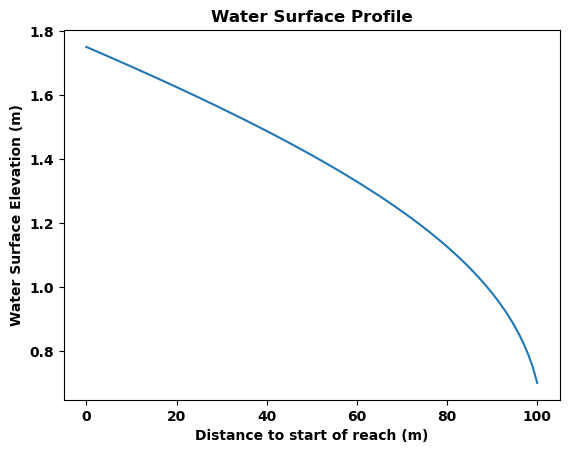

In [40]:
# Extract water surface profile
# Assuming the known HDF structure for steady flow

with h5py.File(hdf_file, 'r') as f:
    wse_data = f['Results/Steady/Output/Output Blocks/Base Output/Steady Profiles/Cross Sections/Water Surface']
    print("Water Surface shape:", wse_data.shape)
    
    # Assuming it's 2D: profiles x stations
    wse = wse_data[0, :]  # First profile
    
    # Get river stations from geometry
    geom_info = f['Results/Steady/Output/Geometry Info']
    node_info = geom_info['Node Info']
    
    # Parse stations from node_info strings
    import re
    river_stations = []
    for info in node_info:
        info_str = info.decode('utf-8')
        # Extract the number before ' XS'
        match = re.search(r'(\d+\.?\d*\*?)\s+XS', info_str)
        if match:
            station_str = match.group(1).rstrip('*')
            river_stations.append(float(station_str))
        else:
            river_stations.append(0.0)  # fallback
    
    print("Parsed River Stations:", river_stations[:10])  # First 10
    
    # Distance to end: max station - current station
    import numpy as np
    river_stations = np.array(river_stations)
    max_station = np.max(river_stations)
    distances_to_end = max_station - river_stations
    
    # Create DataFrame with distance to end as index
    df = pd.DataFrame({'wse [m]': wse}, index=distances_to_end)
    df.index.name = 'Distance to start [m]'
    display(df)
    
    # Plot
    plt.plot(distances_to_end, wse)
    plt.xlabel('Distance to start of reach (m)')
    plt.ylabel('Water Surface Elevation (m)')
    plt.title('Water Surface Profile')
    plt.show()